In [67]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import weightstats
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('kc_house_data_train.csv')

In [68]:
df= df.drop(columns= 'Unnamed: 0')

In [69]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028


In [72]:
cols_of_interest = ['bedrooms', 'bathrooms', 'sqft_living', 'floors',
                    'lat', 'long', 'price']
df= df[cols_of_interest]

# Convert house price to 1000s of dollars
df['price'] = df['price']/1000

/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
df

,bedrooms,bathrooms,sqft_living,floors,lat,long,price
0,4,2.25,2070,2.0,47.4388,-122.162,0.3650
1,5,3.00,2900,1.0,47.6784,-122.285,0.8650
2,4,2.50,3770,2.0,47.5646,-122.129,1.0380
3,3,3.50,4560,2.0,47.6995,-122.228,1.4900
4,3,2.50,2550,2.0,47.6647,-122.083,0.7110
...,...,...,...,...,...,...,...
17285,5,2.50,3240,1.0,47.5858,-122.112,0.7500
17286,2,1.75,1300,2.0,47.6687,-122.288,0.4400
17287,3,1.00,1050,1.0,47.7635,-122.262,0.3100
17288,3,1.50,1900,1.5,47.4199,-121.990,0.4275


In [74]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(df, test_size=0.25, random_state=42)

print('Train Set: {0:0.2f}%'.format(100*train_df.size/df.size))
print('Validation Set: {0:0.2f}%'.format(100*val_df.size/df.size))
print('Test Set: {0:0.2f}%'.format(100*test_df.size/df.size))

Train Set: 75.00%
Validation Set: 25.00%
Test Set: 20.00%


In [75]:
X = train_df[cols_of_interest]
y = train_df['price']
print(X.shape)
print(y.shape)

(12967, 7)
(12967,)


,x,z_manual,z_sklearn
count,17290.000000,1.729000e+04,1.729000e+04
mean,2081.464604,-2.657087e-17,-5.296836e-17
std,920.018539,1.000000e+00,1.000029e+00
min,290.000000,-1.947205e+00,-1.947261e+00
25%,1430.000000,-7.080994e-01,-7.081199e-01
50%,1920.000000,-1.755015e-01,-1.755065e-01
75%,2550.000000,5.092673e-01,5.092821e-01
max,13540.000000,1.245468e+01,1.245504e+01


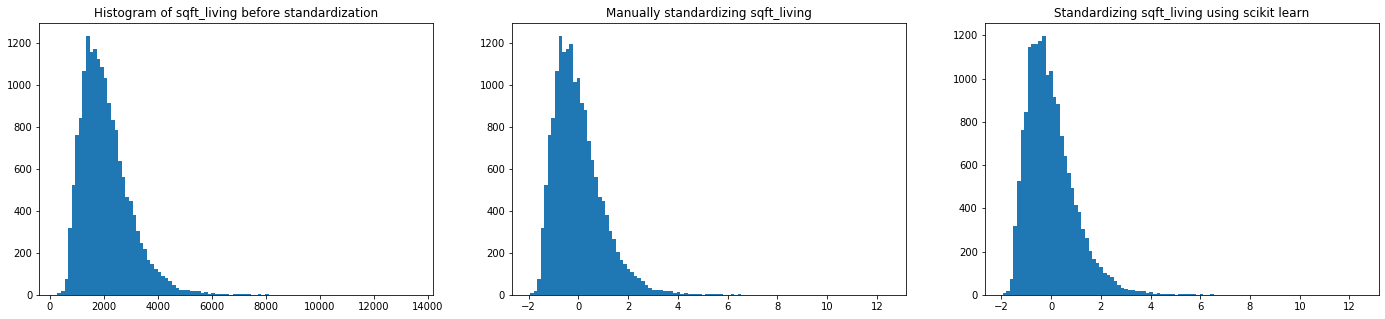

In [76]:
x = df['sqft_living']
mu = x.mean()
sigma = x.std()
z = (x-mu)/sigma

x_reshaped = np.array(x).reshape(-1,1)
z_sklearn = StandardScaler().fit_transform(x_reshaped)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
ax = ax.ravel()

ax[0].hist(x, bins=100)
ax[0].set_title('Histogram of sqft_living before standardization')

ax[1].hist(z, bins=100)
ax[1].set_title('Manually standardizing sqft_living')

ax[2].hist(z_sklearn, bins=100)
ax[2].set_title('Standardizing sqft_living using scikit learn');
pd.DataFrame({'x': x, 'z_manual': z, 'z_sklearn': z_sklearn.flatten()}).describe()

In [80]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'lat', 'long']

X_train = train_df[features]
y_train = np.array(train_df['price']).reshape(-1,1)

X_val = val_df[features]
y_val = np.array(val_df['price']).reshape(-1,1)

X_test = test_df[features]
y_test = np.array(test_df['price']).reshape(-1,1)

scaler = StandardScaler().fit(X_train)
X_train_t = scaler.transform(X_train)
X_val_t = scaler.transform(X_val)
X_test_t = scaler.transform(X_test)
X_train_df = pd.DataFrame(X_train_t, columns=features)
X_val_df = pd.DataFrame(X_val_t, columns=features)
X_test_df = pd.DataFrame(X_test_t, columns=features)

scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

In [81]:
from statsmodels.regression.linear_model import OLS
model_1 = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     3138.
Date:                Sun, 14 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:56:30   Log-Likelihood:                -12583.
No. Observations:               12967   AIC:                         2.518e+04
Df Residuals:                   12960   BIC:                         2.523e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.979e-15      0.006  -1.07e-12      1.000      -0.011       0.011
bedrooms       -0.1323      0.007    -19.098      0.000      -0.146      -0.119
bathrooms       0.0376      0.009      3.997      0.000       0.019       0.056
sqft_living     0.7696      0.009     84.092      0.000       0.752       0.788
floors         -0.0062      0.007     -0.945      0.345      -0.019       0.007
lat             0.2457      0.006     43.205      0.000       0.235       0.257
long           -0.1204      0.006    -20.560      0.000      -0.132      -0.109
==============================================================================
Omnibus:                     9823.681   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           483609.526
Skew:                           3.176   Prob(JB):                         0.00
Kurtosis:                      32.236   Cond. No.                         3.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""